# OBJECTIVE

# STEPS THAT I HAVE FOLLOWED

# IMPORTING MODULES

In [2]:
#warnings.filterwarnings("ignore")
%matplotlib inline
import warnings
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


D:\python\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  Using the SQLite Table to read data.

In [3]:

con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# REMOVING DUBLICATES

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.


In [7]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [8]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'being', 'i', 'over', 'here', "isn't", 'should', 'you', 'so', 'of', 'weren', 'these', 'out', 'now', 'very', 'any', 'did', "that'll", 'just', 'doesn', 'needn', "needn't", 'shan', 'most', "aren't", 'by', 's', 'had', 'off', 'we', 'after', 'doing', 'she', 'him', 'isn', 'me', 'wouldn', 'in', 'aren', 'ourselves', 't', 'be', 'too', 'have', 'and', 'all', "won't", "she's", 'do', "you've", 'myself', "should've", 'yours', 'our', 'than', 'ours', 'the', 'with', 'he', 'into', 'this', "mightn't", 'their', "wouldn't", 'mustn', 'there', 'some', 'an', "wasn't", 'ain', 'while', 'will', 'yourselves', 'more', 'other', 'each', 'herself', 'when', 'won', 'not', 'under', 'itself', 'to', 'yourself', 'were', 'from', 'they', 'your', 'below', 'again', 'can', "you're", 'theirs', "hadn't", 'hasn', 'them', 'didn', 're', 'is', 'whom', "mustn't", 'until', 'am', 'against', 'those', 'if', "couldn't", 'once', 'both', 'hadn', 'o', 'been', 'haven', 'before', 've', 'on', 'don', 'further', 'that', 'ma', 'his', 'hers', 'nor',

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [10]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# TAKING 2K POINTS

In [11]:
b=final['Score'][:2000].values
F=final['CleanedText'][:2000].values

#  Avg W2V

In [12]:
#os.path.isfile('google_w2v_for_amazon.pkl'):
with open('google_w2v_for_amazon.pkl', 'rb') as f:
    model = pickle.load(f)

In [13]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in F:
    list_of_sent.append(sent.split())

In [14]:
print(F)
print("*****************************************************************")
print(list_of_sent[0])

['witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'
 'grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open'
 'fun way children learn month year learn poem throughout school year like handmot invent poem'
 ...
 'never cat lover oldest one follow home year old weight less lbs first met sensent system food alleri lot thing tri coupl differ cat dri food found one would eat doesnt food allergi black cat shini coat vet said healthi host neightbor cat almost month neightbor away cat love cat food coat start shinni eat cat food one month gave neighbor sampl found cat realli like'
 'prompt deliveri product use everi day didnt drag bag home store thank'
 'pom predispos collaps trachea luxat patella spell correct use along sever supplement herb dog wond

In [15]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [16]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2292
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'hes', 'learn', 'love', 'new', 'word', 'introduc', 'classic', 'will', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'movi', 'howev', 'miss', 'hard', 'cover', 'version', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand', 'keep', 'page', 'open', 'fun', 'way', 'children', 'month', 'year', 'poem', 'throughout']


In [17]:
warnings.filterwarnings("ignore")
w2v_model.wv.most_similar('tasti')


[('top', 0.9992796778678894),
 ('mean', 0.9992645382881165),
 ('christma', 0.9992632865905762),
 ('fresh', 0.9992468357086182),
 ('fair', 0.9992359280586243),
 ('remov', 0.9992358088493347),
 ('bubbl', 0.9992269277572632),
 ('prefer', 0.9992203116416931),
 ('come', 0.9992167949676514),
 ('wheat', 0.999215304851532)]

In [18]:
len(w2v_model.wv['color'])

50

In [22]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent[:2000]): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 577.20it/s]


2000
50


In [23]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors)
print(standardized_data.shape)
warnings.filterwarnings("ignore")

(2000, 50)



# T-SNE

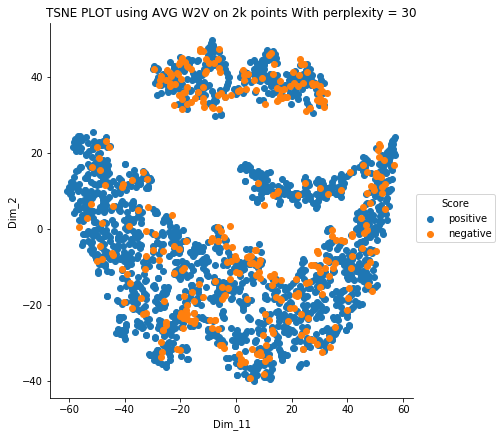

In [24]:
from sklearn.manifold import TSNE





model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data = model.fit_transform(standardized_data) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, b)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_11", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_11', 'Dim_2').add_legend()
plt.title('TSNE PLOT using AVG W2V on 2k points With perplexity = 30')
plt.show()

# BOW

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(F)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 6858)
the number of unique words  6858


In [26]:
A=final_counts.toarray()
A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# STANDARDIZING THE DATA

In [27]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(A)
print(standardized_data.shape)
warnings.filterwarnings("ignore")

(2000, 6858)


# TSNE USING BAG OF WORDS

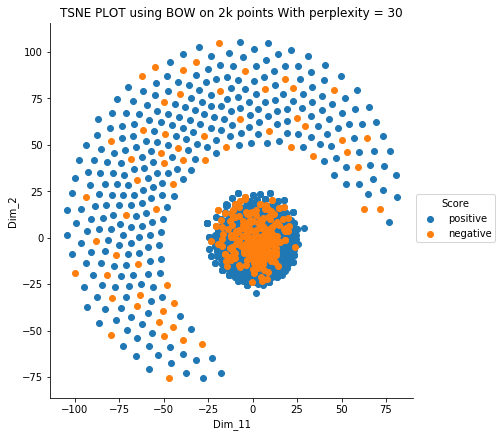

In [29]:
from sklearn.manifold import TSNE





model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data = model.fit_transform(standardized_data) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, b)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_11", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_11', 'Dim_2').add_legend()
plt.title('TSNE PLOT using BOW on 2k points With perplexity = 30')
plt.show()

# TF_IDF

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(F)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 76693)
the number of unique words including both unigrams and bigrams  76693


In [31]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[700:710])

some sample features(unique words in the corpus) ['adjac mole', 'adjac new', 'adjust', 'adjust eventu', 'adjust necessari', 'adjust problem', 'adjust quit', 'adjust regular', 'adjust releas', 'adjust set']


In [32]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [33]:
top_tfidf

,feature,tfidf
0,version paperback,0.167682
1,incorpor love,0.167682
2,two hand,0.167682
3,keep page,0.167682
4,kind flimsi,0.167682
5,page open,0.167682
6,book watch,0.167682
7,hard cover,0.167682
8,paperback seem,0.167682
9,flimsi take,0.167682


In [34]:
A1=final_tf_idf.toarray()

# STANDERDIZED DATA

In [35]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(A1)
print(standardized_data.shape)
warnings.filterwarnings("ignore")

(2000, 76693)


# TSNE USING TF_IDF

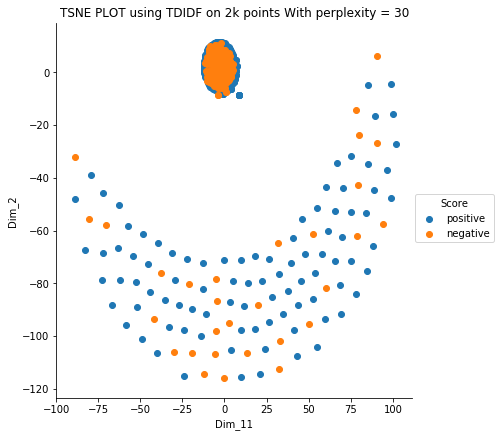

In [38]:
from sklearn.manifold import TSNE




model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data = model.fit_transform(standardized_data) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, b)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_11", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_11', 'Dim_2').add_legend()
plt.title('TSNE PLOT using TDIDF on 2k points With perplexity = 30')
plt.show()

#  TFIDF-W2V

In [40]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(F)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
 #TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent[:2000]): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 273.10it/s]


# STANDERDIZING THE DATA

In [42]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)
warnings.filterwarnings("ignore")

(2000, 50)


# TSNE USING TF_IDF_W2V

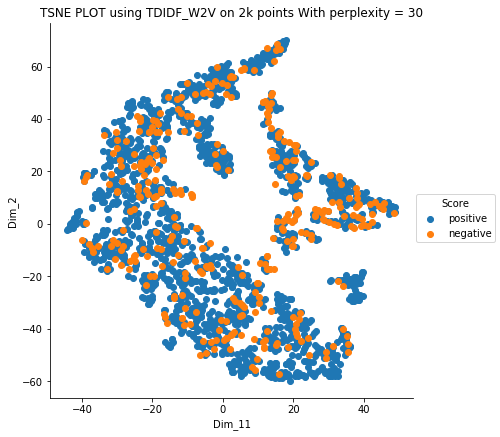

In [43]:
from sklearn.manifold import TSNE



model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data = model.fit_transform(standardized_data) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, b)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_11", "Dim_2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_11', 'Dim_2').add_legend()
plt.title('TSNE PLOT using TDIDF_W2V on 2k points With perplexity = 30')
plt.show()